# Baseline

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import numpy as np
import pandas as pd
from fbprophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas_datareader import data as pdr

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [6]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [7]:
INSTRUMENT = 'MSFT' # Microsoft corp
START_FROM = '2018-11-14'
END_DATE = '2020-01-01'
WINDOW_SIZE = 15
FORECAST_OFFSET=1
VAL_SPLIT = '2019-11-01'
TEST_SPLIT = '2019-12-01'

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [8]:
instr = MarketData.create_from_tiingo(INSTRUMENT, start=START_FROM, end=END_DATE)

## Целевая переменная

Цена закрытия.

In [9]:
orig_target = instr.c

Переходим к логарифмической доходности.

In [10]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'c': price_transformer(),
    }
    return feature_transformations

In [11]:
instr_transformed = instr.select_transform(make_feature_selector())

## Обучающая, валидационная и тестовая выборки

In [12]:
instr_train, instr_val_test = instr_transformed.train_test_split(VAL_SPLIT, window_size=WINDOW_SIZE,
                                                                 scaler=None)
#                                                                  scaler=MinMaxScaler,
#                                                                  scaler_kwargs={'feature_range': (-1, 1)})

instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_val), len(instr_test)

(208, 35, 36)

# *Модели*

## Регрессия: случайное блуждание

Прогноз - следующее значение равно предыдущему, то есть прогнозируемая доходность - постоянная и равная 0.

In [13]:
pred_log_ret_test = np.zeros(len(instr_test) - WINDOW_SIZE)

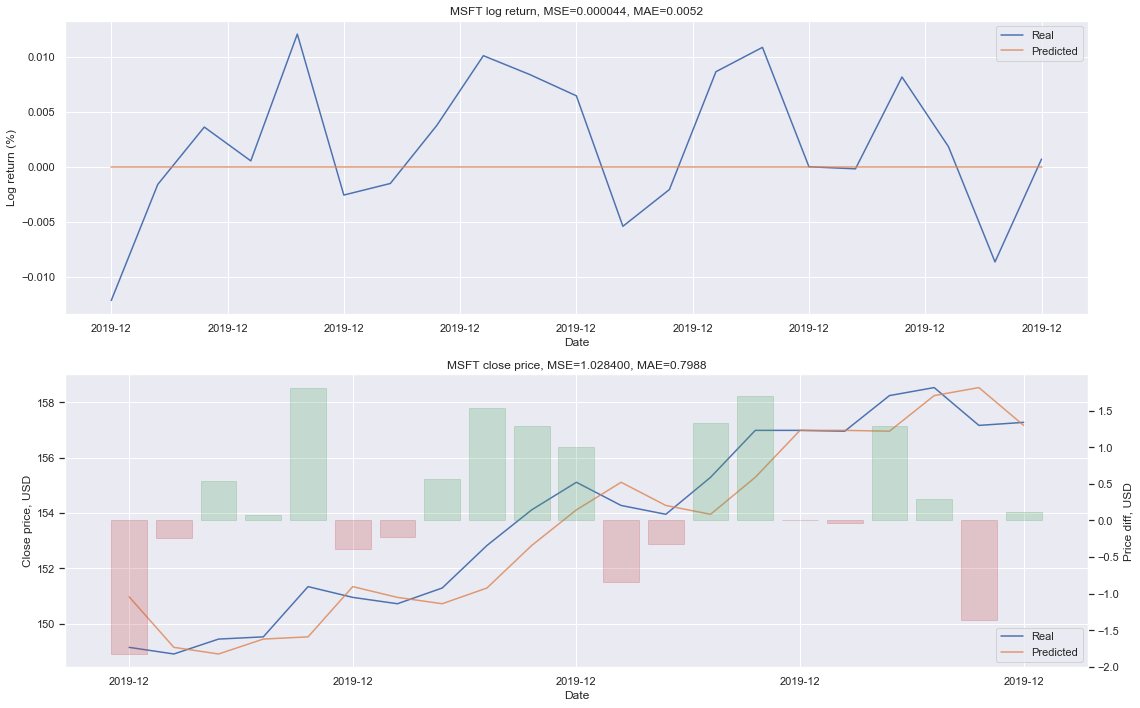

In [14]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 10))

## Классификация: подбрасывание монеты

Метрики классификации в данном случае, очевидно, практического смысла не имеют: хотя в среднем ROC AUC будет равен 0.5, но в какой-то отдельной реализации он может случайно получиться относительно большой. Тем не менее для примера посчитаем метрики и здесь.

In [15]:
pred_direction_proba = np.random.uniform(size=len(instr_test))
predicted_direction = (0.5 < pred_direction_proba).astype(np.int)

true_direction = ClassificationGenerator.get_target_direction(instr_test.c[-len(pred_direction_proba):].data)

In [16]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.40      0.33      0.36        12
           1       0.69      0.75      0.72        24

    accuracy                           0.61        36
   macro avg       0.55      0.54      0.54        36
weighted avg       0.59      0.61      0.60        36



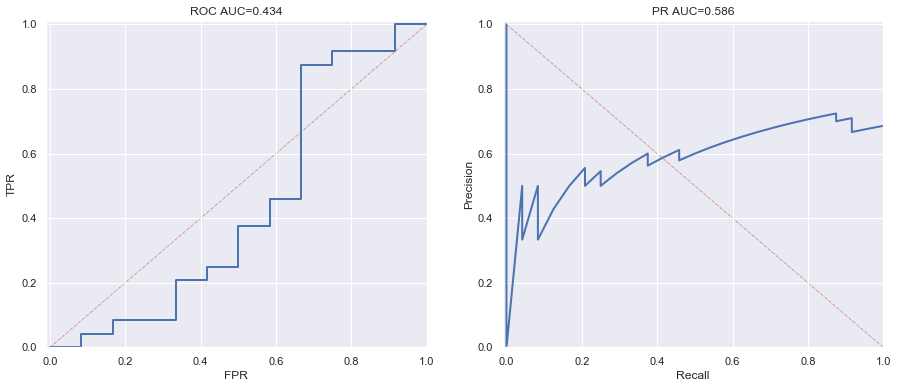

In [17]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

## [Prophet](https://facebook.github.io/prophet/docs/quick_start.html)

Также посмотрим прогноз, который может сделать аддитивная модель библиотеки [FB Prophet](https://facebook.github.io/prophet) "из коробки".

На вход принимает датафрейм заданного формата.

In [18]:
prophet_train = pd.DataFrame(instr_train.c.asSeries()).reset_index()

prophet_train.columns = ['ds', 'y']

prophet_train.tail()

,ds,y
203,2019-10-25,0.005629
204,2019-10-28,0.024289
205,2019-10-29,-0.009477
206,2019-10-30,0.012385
207,2019-10-31,-0.008612


#### Обучение:

In [19]:
prophet = Prophet()

prophet.fit(prophet_train);

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Для сохранения результата прогноза также нужен датафрейм.

In [20]:
prophet_test = pd.DataFrame(instr_test.timestamps[WINDOW_SIZE:])

prophet_test.columns = ['ds']

prophet_test.head()

,ds
0,2019-12-02
1,2019-12-03
2,2019-12-04
3,2019-12-05
4,2019-12-06


#### Прогноз:

In [21]:
prophet_test = prophet.predict(prophet_test)

In [22]:
prophet_test.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
16,2019-12-24,-0.000950,-0.018449,0.013987,-0.000950,-0.000950,-0.001048,-0.001048,-0.001048,-0.001048,-0.001048,-0.001048,0.0,0.0,0.0,-0.001998
17,2019-12-26,-0.000971,-0.014168,0.018709,-0.000971,-0.000971,0.003325,0.003325,0.003325,0.003325,0.003325,0.003325,0.0,0.0,0.0,0.002354
18,2019-12-27,-0.000981,-0.018888,0.014874,-0.000981,-0.000981,-0.000523,-0.000523,-0.000523,-0.000523,-0.000523,-0.000523,0.0,0.0,0.0,-0.001505
19,2019-12-30,-0.001013,-0.018730,0.014192,-0.001013,-0.001013,-0.001046,-0.001046,-0.001046,-0.001046,-0.001046,-0.001046,0.0,0.0,0.0,-0.002058
20,2019-12-31,-0.001023,-0.018811,0.013936,-0.001023,-0.001023,-0.001048,-0.001048,-0.001048,-0.001048,-0.001048,-0.001048,0.0,0.0,0.0,-0.002071


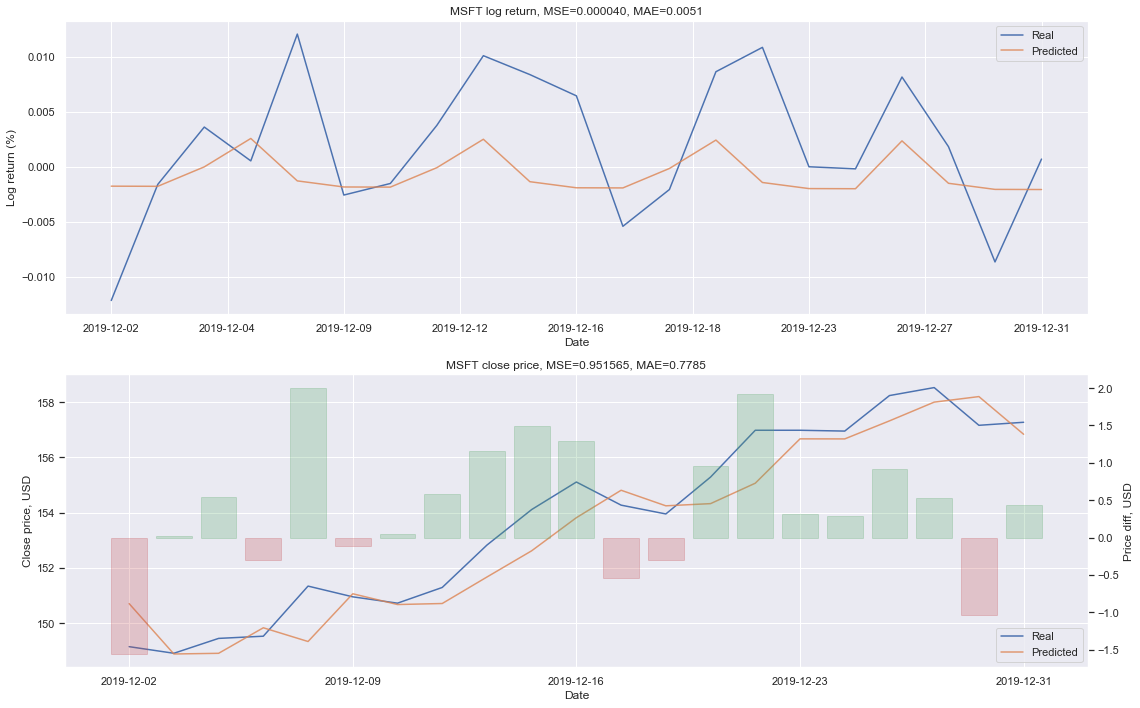

In [23]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, prophet_test['yhat'].values, datetime_unit='D')

Прогноз с доверительными интервалами:

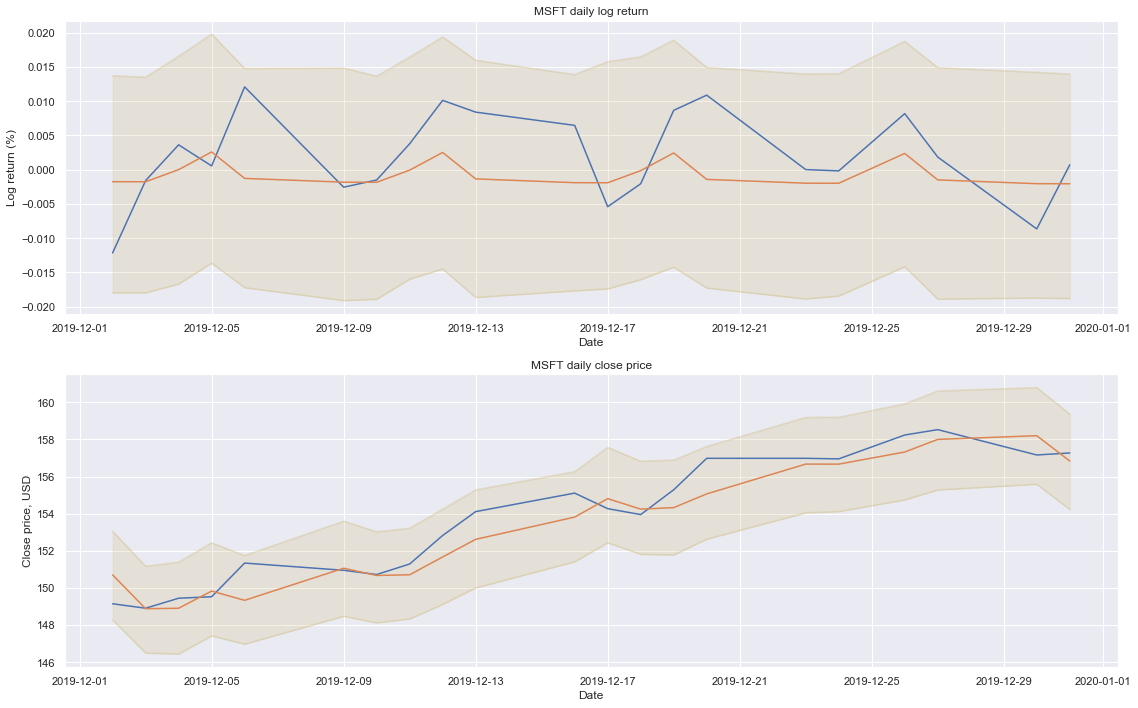

In [24]:
plotHelpers.plot_fbprohet_spread(orig_target, instr_test, prophet_test)

### Вывод

**Prophet** прогнозирует что-то близкое к модели случайного блуждания.